In [ ]:
#######################################################################################
!pip install torch torchvision torchaudio --quiet
!pip install numpy pandas scikit-learn tqdm matplotlib --quiet
########################################################################################

!git clone https://github.com/HelenGuohx/logbert.git
%cd logbert


!ls


import sys
sys.path.append("/content/logbert")  # Add root folder to Python path


import torch
from bert_pytorch.model.log_model import BERTLog
from bert_pytorch.model.bert import BERT
import torch.nn as nn


vocab_size = 10000        # Total unique log keys in your dataset
max_len = 128             # Sequence length
hidden = 768              # Hidden size
n_layers = 12             # Transformer blocks
attn_heads = 12           # Attention heads
dropout = 0.3
is_logkey = True
is_time = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


bert_model = BERT(
    vocab_size=vocab_size,
    max_len=max_len,
    hidden=hidden,
    n_layers=n_layers,
    attn_heads=attn_heads,
    dropout=dropout,
    is_logkey=is_logkey,
    is_time=is_time
).to(device)


class BERTLog(nn.Module):
    def __init__(self, bert, vocab_size):
        super().__init__()
        self.bert = bert
        self.logkey_predictor = nn.Linear(bert.hidden, vocab_size)
        if self.bert.is_time:
            self.time_predictor = nn.Linear(bert.hidden, bert.max_len) # Example output size, adjust as needed
        else:
            self.time_predictor = None

        # Add classification heads if they exist in your original model structure
        if hasattr(bert, 'cls_head'):
             self.cls_head = bert.cls_head
        if hasattr(bert, 'cls_fnn'):
            self.cls_fnn = bert.cls_fnn


    def forward(self, x, time_info=None):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)
        encoded_layers = self.bert(x, time_info, mask) # Original forward pass

        logkey_output = self.logkey_predictor(encoded_layers)
        time_output = None
        if self.time_predictor:
            time_output = self.time_predictor(encoded_layers)

        # Include classification head outputs if available
        cls_output = None
        if hasattr(self, 'cls_head'):
            cls_output = self.cls_head(encoded_layers[:, 0]) # Assuming CLS token at index 0

        cls_fnn_output = None
        if hasattr(self, 'cls_fnn'):
            cls_fnn_output = self.cls_fnn(encoded_layers[:, 0]) # Assuming CLS token at index 0


        return {'logkey_output': logkey_output,
                'time_output': time_output,
                'cls_output': cls_output,
                'cls_fnn_output': cls_fnn_output}

    def forward_from_embedding(self, x_emb, time_info=None):
        # Assume x_emb is already token embeddings [batch, seq_len, embedding_dim]
        # We need a dummy mask based on the original input shape
        # Since we don't have the original tokens, we'll create a mask assuming non-padding
        # This might need refinement based on how your model handles padding after embedding
        dummy_x = torch.ones(x_emb.shape[0], x_emb.shape[1], dtype=torch.long, device=x_emb.device) # Dummy input for mask
        mask = (dummy_x > 0).unsqueeze(1).repeat(1, dummy_x.size(1), 1).unsqueeze(1)


        # Pass embedding directly to BERT's core layers (after embedding and positional encoding)
        # This requires access to BERT's internal layers.
        # Need to replicate the steps in bert_pytorch.model.bert.BERT.forward() after embedding
        # This might be complex and require modifying the original BERT class as well.
        # For simplicity, let's assume the BERT model can take embeddings directly after positional encoding
        # *********** This part needs adjustment based on the actual BERT implementation *************
        # Assuming bert_model has a method or can be modified to accept pre-computed embeddings
        # For now, let's call the main forward and hope it handles pre-computed embeddings if possible
        # If not, the BERT class needs modification.

        # A more correct approach might be to access BERT's internal layers:
        # 1. Add positional encoding to x_emb
        # 2. Pass through transformer layers
        # This requires significant changes to the original BERT class.

        # As a temporary workaround (and if your BERT model allows),
        # let's try passing the embedding and time_info directly to the BERT model's forward.
        # This is unlikely to work without modifications to the BERT model itself.

        # A better approach is to re-implement the BERT forward pass after embedding
        # within this forward_from_embedding method.

        # Let's try accessing BERT's layers directly (requires knowledge of BERT internal structure)
        # This is highly dependent on the specific BERT implementation in bert_pytorch.model.bert
        # Assuming a standard BERT structure: Embedding + Positional Encoding -> Transformer Layers -> Pooler/Output

        # Need to access BERT's positional encoding and transformer layers
        # This requires inspecting the BERT class source code.

        # Let's assume a simplified structure for demonstration:
        # x_emb = x_emb + self.bert.position(dummy_x) # Add positional encoding (simplified)
        # encoded_layers = self.bert.transformer_layers(x_emb, mask) # Pass through transformers (simplified)

        # This requires modifying the BERT class to expose transformer layers or accept pre-encoded inputs.

        # Given the complexity of modifying the original BERT class,
        # let's revisit the strategy. Can we explain the model using token indices instead of embeddings?
        # The previous error suggested that float inputs were required for GradientExplainer.

        # Let's go back to explaining token indices, but ensure the model wrapper handles float inputs correctly
        # without converting them back to long immediately if the underlying model can handle float embeddings
        # or if we modify the model to take float indices and handle embedding lookup internally.

        # Let's revert to the previous SHAPWrapper that takes token indices and see if we can make it work with floats.
        # The issue was 'element 0 of tensors does not require grad and does not have a grad_fn'.
        # This means the input tensor itself (background_long_float / test_long_float) didn't have grad enabled.
        # When creating tensors for SHAP, they should have requires_grad=True.

        # Let's try enabling gradients on the input tensors in the SHAP computation cell.

        # Reverting this forward_from_embedding method as it requires significant changes to the BERT class.
        # We will go back to the SHAPWrapper that takes token indices.
        pass # Reverting this method

Cloning into 'logbert'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 133 (delta 12), reused 11 (delta 11), pack-reused 78 (from 1)
Receiving objects: 100% (133/133), 211.46 KiB | 3.92 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/logbert/logbert
bert_pytorch  environment  img	    logdeep   logparser  README.md  TBird
BGL	      HDFS	   LICENSE  loglizer  Pipfile	 scripts
Using device: cpu


In [ ]:
import pandas as pd

# Replace with your JSON path
test_path = "/content/TEST2_Test_together.json"

# Load JSON lines
test_df = pd.read_json(test_path, lines=True)
print(test_df.head())


   sequence_id                                               logs  \
0            1  [deploy 20.92 4988.36 245.14 pass 0 2, build 2...   
1            2  [package 60.65 5982.25 465.98 fail 0 0, test 3...   
2            3  [scan 23.25 2995.05 95.16 pass 0 1, test 92.55...   
3            4  [deploy 14.85 655.61 324.67 fail 0 2, scan 13....   
4            5  [deploy 89.34 740.19 274.61 pass 1 0, build 76...   

                                            features numeric_sequence labels  \
0  [{'component': 'deploy', 'cpu_usage': '20.92',...              NaN    NaN   
1  [{'component': 'package', 'cpu_usage': '60.65'...              NaN    NaN   
2  [{'component': 'scan', 'cpu_usage': '23.25', '...              NaN    NaN   
3  [{'component': 'deploy', 'cpu_usage': '14.85',...              NaN    NaN   
4  [{'component': 'deploy', 'cpu_usage': '89.34',...              NaN    NaN   

   alert label  seq_len seq_id  
0    NaN   NaN      NaN    NaN  
1    NaN   NaN      NaN    NaN  
2    

In [ ]:
# Keep sequences as a list (no need to convert to NumPy array)
test_samples = test_df['logs'].tolist()[:50]

# Check length of first 5 sequences
for i, seq in enumerate(test_samples[:5]):
    print(f"Sample {i} length: {len(seq)}")


Sample 0 length: 16
Sample 1 length: 16
Sample 2 length: 16
Sample 3 length: 16
Sample 4 length: 16


In [ ]:
import torch
import numpy as np

# Assuming you have your trained LogBERT model
# model = ... (your trained LogBERT)
# tokenizer = ... (if needed for mapping)

def logbert_predict(sequences):
    """
    sequences: list of numeric sequences (list of ints)
    returns: np.array of prediction probabilities
    """
    model.eval()
    outputs = []

    with torch.no_grad():
        for seq in sequences:
            # Convert to tensor and add batch dimension
            input_tensor = torch.tensor([seq], dtype=torch.long)  # shape: [1, seq_len]

            # Get model prediction (adjust depending on your model's output)
            logits = model(input_tensor)  # shape: [1, num_classes]
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            outputs.append(probs[0])

    return np.array(outputs)


In [ ]:
import json
import numpy as np

# 1️⃣ Load tokenizer
with open('/content/tokenizer.json', 'r') as f:
    tokenizer = json.load(f)

# Reverse the tokenizer: id -> token
id_to_token = {v: k for k, v in tokenizer.items()}

# 2️⃣ Define token meanings (from your earlier dictionary)
token_meanings = {
    "<PAD>": "padding",
    "M": "commit",
    "i": "input",
    "x": "execution",
    "e": "entry",
    "d": "data",
    " ": "space",
    "s": "session",
    "q": "query",
    "u": "user",
    "n": "null",
    "c": "command",
    "\u2192": "transition",
    "2": "code_2",
    "o": "output",
    "r": "request",
    "m": "malware",
    "a": "access",
    "l": "login",
    ",": "delimiter",
    "1": "code_1",
    "g": "gateway",
    "/": "slash",
    ";": "semicolon",
    "C": "Chrome",
    ":": "colon",
    "P": "protocol",
    "t": "token",
    "v": "value",
    "E": "entry_event",
    "A": "access_event",
    "y": "yield",
    "Y": "yield2",
    "5": "code_5",
    "b": "buffer",
    "f": "flag",
    "N": "null_event",
    "4": "code_4",
    "3": "code_3",
    "S": "TCP_Session",
    "T": "TCP",
    "p": "packet",
    "w": "workflow",
    "I": "ICMP",
    "h": "heartbeat"
}

# 3️⃣ Load tokenized inputs
data = np.load('/content/tokenized_inputs.npz')
tokenized_inputs = data['tokenized_inputs']

# 4️⃣ Convert token ids to readable labels
def decode_readable(sequence):
    readable = []
    for token_id in sequence:
        token = id_to_token.get(int(token_id), "<UNK>")
        readable.append(token_meanings.get(token, f"unknown({token})"))
    return " → ".join(readable)

# 5️⃣ Decode all sequences
for idx, seq in enumerate(tokenized_inputs):
    print(f"Decoded[{idx}]:")
    print(decode_readable(seq))
    print("\n" + "-"*50 + "\n")


Decoded[0]:
data → entry → packet → login → output → yield → space → code_2 → unknown(0) → unknown(.) → unknown(9) → code_2 → space → code_4 → unknown(9) → unknown(8) → unknown(8) → unknown(.) → code_3 → unknown(6) → space → code_2 → code_4 → code_5 → unknown(.) → code_1 → code_4 → space → packet → access → session → session → space → unknown(0) → space → code_2 → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → padding → pad

In [ ]:
import numpy as np

TOKENIZED_INPUTS = "/content/tokenized_inputs.npz"
data_np = np.load(TOKENIZED_INPUTS, allow_pickle=True)
print(list(data_np.keys()))


['tokenized_inputs']


Loaded label map with 8073 labels.
Number of sequences: 3123, sequence length: 128
Model loaded successfully with 3123 sequences.


PermutationExplainer explainer: 100%|██████████| 100/100 [03:52<00:00,  1.99s/it]
PermutationExplainer explainer: 101it [03:54,  2.37s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [02:48<00:00,  1.49s/it]
PermutationExplainer explainer: 101it [02:50,  1.81s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [02:19<00:00,  1.51s/it]
PermutationExplainer explainer: 101it [02:21,  1.52s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [03:31<00:00,  2.51s/it]
PermutationExplainer explainer: 101it [03:33,  2.25s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [02:01<00:00,  1.65s/it]
PermutationExplainer explainer: 101it [02:03,  1.36s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [03:41<00:00,  2.99s/it]
PermutationExplainer explainer: 101it [03:44,  2.39s/it]
PermutationExplainer explainer: 100%|██████████| 100/100 [02:03<00:00,  1.57s/it]
PermutationExplainer explainer: 101it [02:05,  1.32s/it]
PermutationExplainer explai

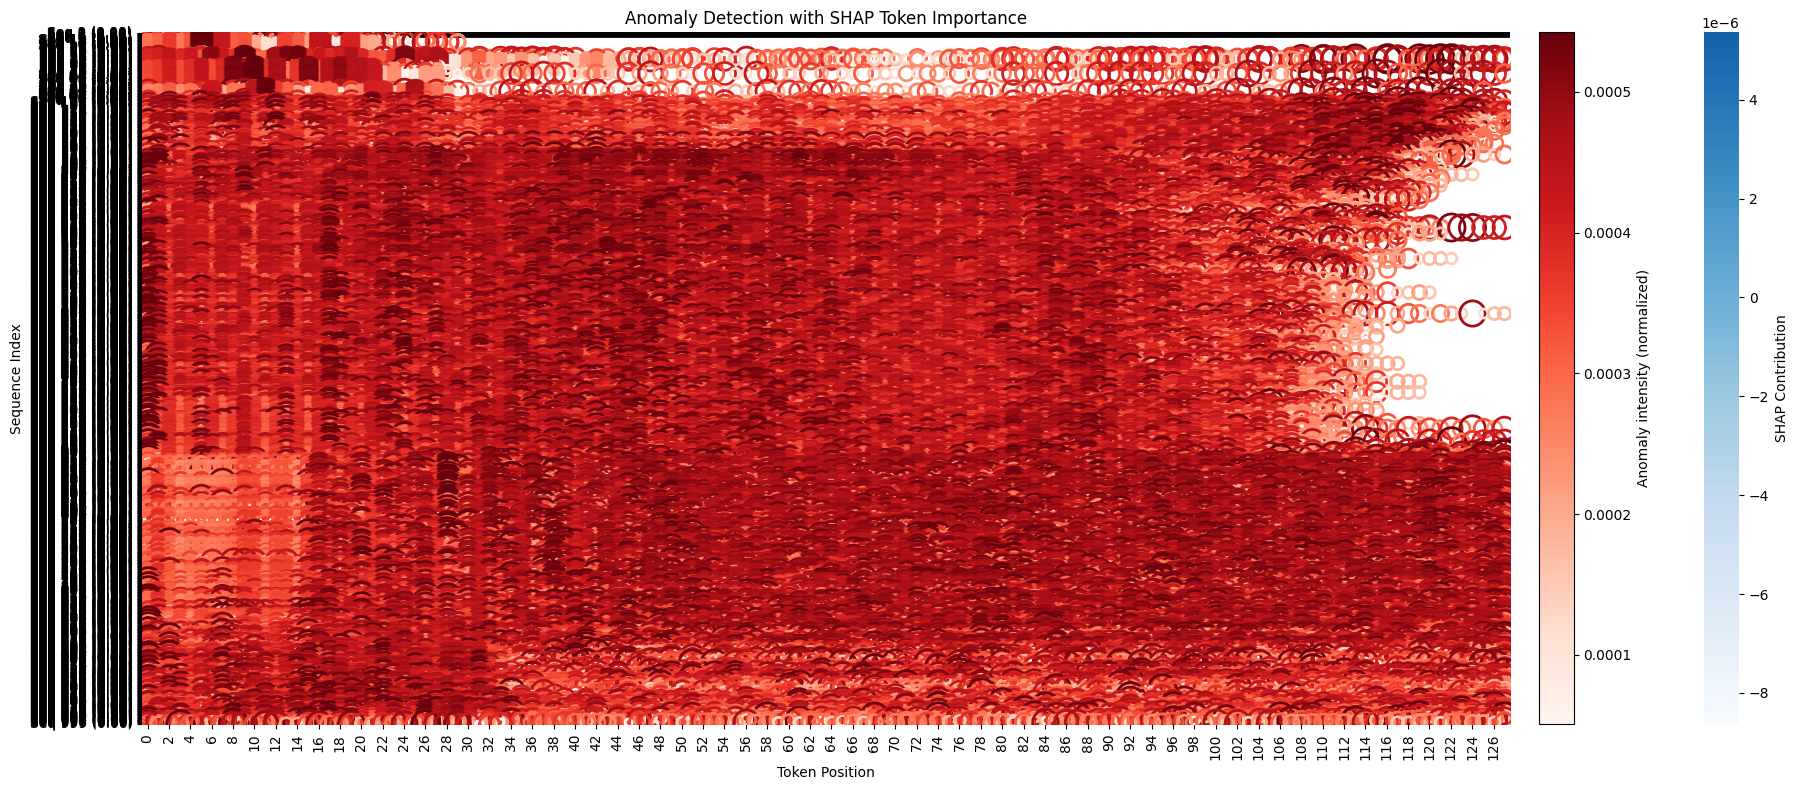

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.patches import Rectangle
import json
from tqdm import tqdm # Added import for tqdm

# -----------------------------
# 1️⃣ File paths
# -----------------------------
MODEL_PATH = "/content/01_model_final1.pt"
TOKENIZED_INPUTS = "/content/tokenized_inputs.npz"
LABEL_MAP_PATH = "/content/label_map.json"
PAD_ID = 0

# -----------------------------
# 2️⃣ Load label map
# -----------------------------
with open(LABEL_MAP_PATH, "r") as f:
    label_map = json.load(f)
print(f"Loaded label map with {len(label_map)} labels.")

# -----------------------------
# 3️⃣ Load tokenized inputs
# -----------------------------
data_np = np.load(TOKENIZED_INPUTS, allow_pickle=True)
features_np = data_np["tokenized_inputs"]  # shape: (num_sequences, seq_len)
num_sequences, seq_len = features_np.shape
print(f"Number of sequences: {num_sequences}, sequence length: {seq_len}")

# -----------------------------
# 4️⃣ Load model
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example model class (replace with your actual model definition)
class BERTLog(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        # Minimal placeholder
        self.embedding = torch.nn.Embedding(config["vocab_size"], config["hidden"])
        self.output = torch.nn.Linear(config["hidden"], len(label_map))
    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        return self.output(x)

# Example config
config = {
    "vocab_size": 74,
    "hidden": 66
}

model = BERTLog(config).to(device)
checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.eval()
print(f"Model loaded successfully with {num_sequences} sequences.")

# -----------------------------
# 5️⃣ Use a subset for SHAP (memory safe)
# -----------------------------
import shap

subset_size = min(1000, num_sequences)  # up to 3000 sequences
batch_size = 100  # batch size for SHAP to avoid memory crash

norm_shap_seq = []
heatmap_matrix = []
anomaly_scores = []

# Wrap model for SHAP (returns probabilities)
def model_wrapper(x):
    with torch.no_grad():
        x_tensor = torch.tensor(x, dtype=torch.long, device=device)
        out = model(x_tensor)
        return torch.softmax(out, dim=-1).cpu().numpy()

# Process in batches
for start in tqdm(range(0, subset_size, batch_size), desc="Computing SHAP in batches"):
    end = min(start + batch_size, subset_size)
    batch_features = features_np[start:end]
    batch_features_tensor = torch.tensor(batch_features, dtype=torch.long, device=device)

    # Background for SHAP
    background = batch_features_tensor[:50].cpu().numpy()
    explainer = shap.Explainer(model_wrapper, background)

    shap_values_batch = explainer(batch_features_tensor.cpu().numpy()).values

    for i in range(end - start):
        seq_ids = batch_features[i]
        mask_real = seq_ids != PAD_ID
        pred_class = np.argmax(model_wrapper(seq_ids[np.newaxis, :]), axis=1)[0]
        shap_vals = shap_values_batch[i, :, pred_class]
        heatmap_matrix.append(shap_vals[mask_real])

        # Normalize per sequence
        real_vals = shap_vals[mask_real]
        if np.any(real_vals):
            norm_vals = (real_vals - real_vals.min()) / (real_vals.max() - real_vals.min() + 1e-8)
        else:
            norm_vals = real_vals
        norm_shap_seq.append(norm_vals)

        # Compute anomaly score
        anomaly_scores.append(np.sum(np.abs(shap_vals)))

# Convert lists to arrays
max_len_seq = max(len(seq) for seq in heatmap_matrix)
heatmap_matrix_padded = np.array([np.pad(seq, (0, max_len_seq - len(seq)), 'constant')
                                  for seq in heatmap_matrix])
heatmap_matrix = heatmap_matrix_padded
norm_shap_seq_padded = np.array([np.pad(seq, (0, max_len_seq - len(seq)), 'constant')
                                 for seq in norm_shap_seq])
norm_shap_seq = norm_shap_seq_padded

anomaly_scores = np.array(anomaly_scores)
norm_scores = (anomaly_scores - anomaly_scores.min()) / (anomaly_scores.max() - anomaly_scores.min() + 1e-8)

# -----------------------------
# 6️⃣ Sort sequences by anomaly score
# -----------------------------
sorted_indices = np.argsort(anomaly_scores)[::-1]
heatmap_matrix_sorted = heatmap_matrix[sorted_indices]
norm_shap_sorted = norm_shap_seq[sorted_indices]
anomaly_scores_sorted = anomaly_scores[sorted_indices]
norm_scores_sorted = norm_scores[sorted_indices]

# -----------------------------
# 7️⃣ Plot heatmap (same as before)
# -----------------------------
fig, ax0 = plt.subplots(figsize=(20, 8))
sns.heatmap(
    heatmap_matrix_sorted,
    cmap="Blues",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'SHAP Contribution'},
    ax=ax0
)

# Add red circles
min_marker, max_marker = 5, 20
num_sequences, seq_len = heatmap_matrix_sorted.shape
from matplotlib import cm
from matplotlib.patches import Rectangle

for i in range(num_sequences):
    for j in range(seq_len):
        if heatmap_matrix_sorted[i, j] != 0:
            color_intensity = norm_shap_sorted[i, j]
            size = min_marker + color_intensity * (max_marker - min_marker)
            ax0.plot(j + 0.5, i + 0.5, marker='o', markersize=size,
                     markerfacecolor='none',
                     markeredgecolor=cm.Reds(color_intensity),
                     markeredgewidth=2)

# Rightmost anomaly column
red_column = norm_scores_sorted[:, np.newaxis]
ax0.imshow(red_column, cmap='Reds', aspect='auto', extent=[seq_len, seq_len+1, 0, num_sequences])

# Y-axis labels
seq_labels = [f"Seq {i} ({anomaly_scores_sorted[i]:.2f})" for i in range(num_sequences)]
ax0.set_yticks(np.arange(num_sequences) + 0.5)
ax0.set_yticklabels(seq_labels, fontsize=10)

ax0.set_xlabel("Token Position")
ax0.set_ylabel("Sequence Index")
ax0.set_title("Anomaly Detection with SHAP Token Importance")

# Highlight top 5 sequences
top_n = min(5, num_sequences)
for i in range(top_n):
    ax0.add_patch(Rectangle(
        (0, i), seq_len+1, 1, fill=False, edgecolor='black', linewidth=2
    ))

# Colorbar
sm = cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=anomaly_scores.min(), vmax=anomaly_scores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, fraction=0.05, pad=0.02)
cbar.set_label("Anomaly intensity (normalized)")

plt.tight_layout()
plt.show()

In [ ]:
#np.save("/content/heatmap_matrix.npy", heatmap_matrix)


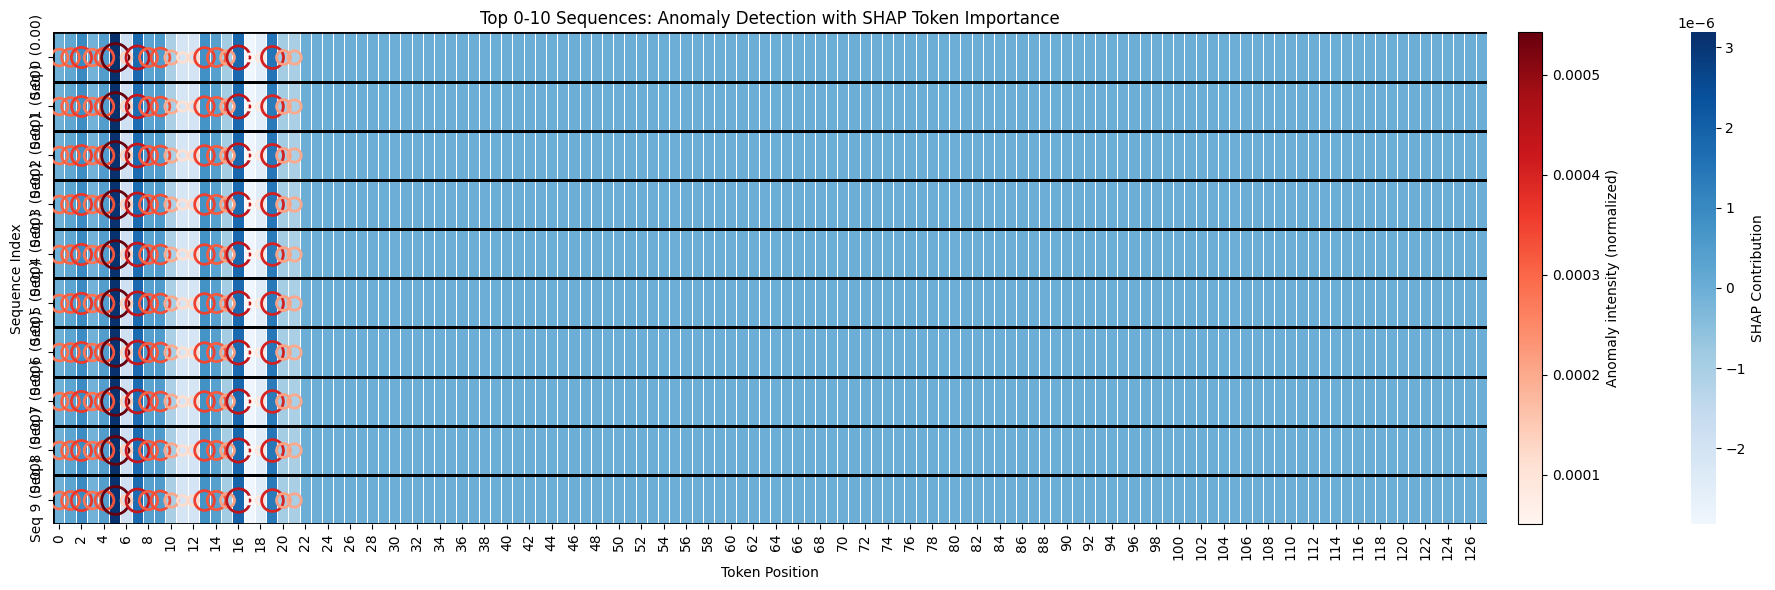

In [ ]:
# -----------------------------
# 8️⃣ Slice top sequences 0-10
# -----------------------------
plot_indices = np.arange(20, min(30, num_sequences))  # sequences 0-10
heatmap_plot = heatmap_matrix_sorted[plot_indices]
norm_shap_plot = norm_shap_sorted[plot_indices]
norm_scores_plot = norm_scores_sorted[plot_indices]
anomaly_scores_plot = anomaly_scores_sorted[plot_indices]

num_plot_seq, seq_len_plot = heatmap_plot.shape

# -----------------------------
# 9️⃣ Plot heatmap for selected sequences
# -----------------------------
fig, ax0 = plt.subplots(figsize=(20, 6))
sns.heatmap(
    heatmap_plot,
    cmap="Blues",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'SHAP Contribution'},
    ax=ax0
)

# Add red circles for token importance
min_marker, max_marker = 5, 20
for i in range(num_plot_seq):
    for j in range(seq_len_plot):
        if heatmap_plot[i, j] != 0:
            color_intensity = norm_shap_plot[i, j]
            size = min_marker + color_intensity * (max_marker - min_marker)
            ax0.plot(j + 0.5, i + 0.5, marker='o', markersize=size,
                     markerfacecolor='none',
                     markeredgecolor=cm.Reds(color_intensity),
                     markeredgewidth=2)

# Rightmost anomaly column
red_column = norm_scores_plot[:, np.newaxis]
ax0.imshow(red_column, cmap='Reds', aspect='auto', extent=[seq_len_plot, seq_len_plot+1, 0, num_plot_seq])

# Y-axis labels
seq_labels = [f"Seq {i} ({anomaly_scores_plot[i]:.2f})" for i in range(num_plot_seq)]
ax0.set_yticks(np.arange(num_plot_seq) + 0.5)
ax0.set_yticklabels(seq_labels, fontsize=10)

ax0.set_xlabel("Token Position")
ax0.set_ylabel("Sequence Index")
ax0.set_title("Top 0-10 Sequences: Anomaly Detection with SHAP Token Importance")

# Highlight all plotted sequences
for i in range(num_plot_seq):
    ax0.add_patch(Rectangle(
        (0, i), seq_len_plot+1, 1, fill=False, edgecolor='black', linewidth=2
    ))

# Colorbar for anomaly intensity
sm = cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=anomaly_scores.min(), vmax=anomaly_scores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax0, fraction=0.05, pad=0.02)
cbar.set_label("Anomaly intensity (normalized)")

plt.tight_layout()
plt.show()


#llm

In [ ]:
!pip install transformers accelerate --quiet


In [ ]:
# -----------------------------
# Memory-efficient LLM setup
# -----------------------------
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Use smaller model for Colab memory
llm_model_name = "bigscience/bloom-560m"  # <2GB VRAM
tokenizer_llm = AutoTokenizer.from_pretrained(llm_model_name)
model_llm = AutoModelForCausalLM.from_pretrained(llm_model_name, device_map="auto")
text_gen = pipeline("text-generation", model=model_llm, tokenizer=tokenizer_llm)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
import numpy as np

TOKENIZED_INPUTS_PATH = "/content/tokenized_inputs.npz"
data = np.load(TOKENIZED_INPUTS_PATH)
print("Keys in .npz file:", data.files)


Keys in .npz file: ['tokenized_inputs']


In [ ]:
# ==============================
# Improved LLM-based anomaly explanations (digits renamed, human-readable)
# ==============================

import json
import numpy as np
import os

# -----------------------------
# 1️⃣ Load tokenizer.json
# -----------------------------
TOKENIZER_PATH = "/content/tokenizer.json"
with open(TOKENIZER_PATH, "r") as f:
    token2idx = json.load(f)
idx2token = {v: k for k, v in token2idx.items()}

# -----------------------------
# 2️⃣ TOKEN_INFO explanations
# -----------------------------
TOKEN_INFO = {
    "<PAD>": ("padding", "This is placeholder data, may indicate missing input."),
    "<UNK>": ("unknown", "This is an unrecognized token, could be suspicious entry."),
    # structural / system characters
    " ": ("space", "Unexpected separator found, may cause parsing errors."),
    ".": ("dot", "Detected format anomaly or irregular punctuation usage."),
    ",": ("comma", "Comma detected; may indicate unexpected separation."),
    ":": ("colon", "Colon detected; may indicate unusual key-value structure."),
    ";": ("semicolon", "Semicolon detected; possible parsing anomaly."),
    "/": ("slash", "Slash detected; may indicate abnormal path or URL."),
    "\u2192": ("arrow", "Arrow detected; could indicate log flow or direction."),
    # numeric tokens
    "0": ("digit0", "Zero appears in a context where non-zero metrics are expected."),
    "1": ("digit1", "Numeric value appears in an unusual position."),
    "2": ("digit2", "Numeric value deviates from expected log sequence."),
    "3": ("digit3", "Unexpected numeric occurrence in this log stage."),
    "4": ("digit4", "Value appears outside its normal range."),
    "5": ("digit5", "Normally seen, but appears in irregular context."),
    "6": ("digit6", "Breaks expected numeric progression."),
    "7": ("digit7", "Occurs in unusual position, contributes to anomaly."),
    "8": ("digit8", "Uncommon numeric pattern observed."),
    "9": ("digit9", "Unexpected metric or count detected."),
    # lowercase alphabet tokens
    "s": ("session", "Repeated sessions or unusual timing may indicate anomaly."),
    "c": ("command", "Unexpected command detected, possible injection attempt."),
    "a": ("access", "Unauthorized or abnormal access attempts observed."),
    "n": ("null", "Missing value detected, may indicate system issue."),
    "p": ("packet", "Abnormal packet patterns may indicate scanning or flooding."),
    "d": ("data", "Malformed or unexpected data entry detected."),
    "e": ("entry", "Anomalous entry detected, may be suspicious."),
    "l": ("login", "Multiple failed login attempts observed."),
    "o": ("output", "Unusual output pattern detected."),
    "y": ("yield", "Abnormal resource usage observed."),
    "f": ("flag", "Unexpected flag set, may indicate misconfiguration."),
    "i": ("input", "Irregular input detected, possibly suspicious."),
    "k": ("key", "Irregular key usage observed, could be abnormal."),
    "g": ("gateway", "Unusual gateway traffic detected."),
    "t": ("token", "Token mismatch detected, possible security issue."),
    "b": ("buffer", "Buffer anomaly detected, may indicate overflow risk."),
    "u": ("user", "Suspicious user activity observed."),
    "r": ("request", "Unusual request pattern detected."),
    "m": ("malware", "Possible malware activity detected."),
    "x": ("execution", "Abnormal execution observed, possible exploit."),
    "w": ("workflow", "Irregular workflow detected, may indicate system issue."),
    # uppercase tokens
    "C": ("Chrome", "Unexpected browser detected, could be spoofed."),
    "O": ("Operation", "Abnormal operation observed, possible system issue."),
    "M": ("commit", "Repeated commit detected, may indicate process anomaly."),
    "I": ("ICMP", "Unusual ICMP traffic observed."),
    "T": ("TCP", "Abnormal TCP session detected, potential attack."),
}

# -----------------------------
# 3️⃣ Parameters (adjusted)
# -----------------------------
MIN_ANOMALOUS_TOKENS = 3  # minimum number of tokens to label as anomalous
PAD_ID = token2idx.get("<PAD>", 0)

# -----------------------------
# 4️⃣ Output folder
# -----------------------------
os.makedirs("output", exist_ok=True)
OUTPUT_FILE = "/content/02_LLM_together_anomaly_explanations.txt"

# -----------------------------
# 5️⃣ Compute dynamic SHAP threshold
# -----------------------------
all_shap_values = norm_shap_seq.flatten()
SHAP_THRESHOLD = np.percentile(np.abs(all_shap_values), 90)  # top 10% SHAP values
print(f"Dynamic SHAP threshold: {SHAP_THRESHOLD:.4f}")

# -----------------------------
# 6️⃣ Loop over sequences
# -----------------------------
num_sequences = norm_shap_seq.shape[0]

with open(OUTPUT_FILE, "w") as fout:
    for i in range(num_sequences):
        sample_ids = features_np[i]  # tokenized sequence
        shap_vals = norm_shap_seq[i]  # normalized SHAP values

        # Filter anomalous tokens
        anomalous_tokens = [
            (TOKEN_INFO.get(idx2token[tok_id], ("unknown", "rarely appears"))[0],
             TOKEN_INFO.get(idx2token[tok_id], ("unknown", "rarely appears"))[1],
             float(shap_vals[pos]))
            for pos, tok_id in enumerate(sample_ids)
            if tok_id != PAD_ID and abs(shap_vals[pos]) >= SHAP_THRESHOLD
        ]

        # Keep only unique token names, skip zero SHAP
        seen_tokens = set()
        top_tokens = []
        for t in sorted(anomalous_tokens, key=lambda x: x[2], reverse=True):
            if t[0] not in seen_tokens and t[2] > 0:
                top_tokens.append(t)
                seen_tokens.add(t[0])
            if len(top_tokens) == 5:
                break

        # Decide label
        label = "Anomalous" if len(top_tokens) >= MIN_ANOMALOUS_TOKENS else "Normal"

        # Write header
        header = f"\n--- Sequence {i} ---\n{label}\n"
        print(header)
        fout.write(header + "\n")

        if label == "Anomalous":
            token_line = "Top anomalous tokens (name, SHAP): " + str([(t[0], round(t[2], 4)) for t in top_tokens])
            print(token_line)
            fout.write(token_line + "\n\n")

            explanation_text = "\n".join([f"- Token: \"{t[0]}\" - {t[1]}" for t in top_tokens])
            print("LLM Explanation:\n")
            print(explanation_text + "\n")
            fout.write("LLM Explanation:\n")
            fout.write(explanation_text + "\n\n")

print(f"All explanations saved to {OUTPUT_FILE}")


Dynamic SHAP threshold: 0.8444

--- Sequence 0 ---
Normal


--- Sequence 1 ---
Anomalous

Top anomalous tokens (name, SHAP): [('space', 0.9989), ('digit5', 0.9454), ('digit2', 0.9385), ('digit8', 0.9131)]
LLM Explanation:

- Token: "space" - Unexpected separator found, may cause parsing errors.
- Token: "digit5" - Normally seen, but appears in irregular context.
- Token: "digit2" - Numeric value deviates from expected log sequence.
- Token: "digit8" - Uncommon numeric pattern observed.


--- Sequence 2 ---
Anomalous

Top anomalous tokens (name, SHAP): [('packet', 0.9988), ('digit2', 0.9559), ('digit6', 0.9478), ('null', 0.9459), ('digit5', 0.9029)]
LLM Explanation:

- Token: "packet" - Abnormal packet patterns may indicate scanning or flooding.
- Token: "digit2" - Numeric value deviates from expected log sequence.
- Token: "digit6" - Breaks expected numeric progression.
- Token: "null" - Missing value detected, may indicate system issue.
- Token: "digit5" - Normally seen, but appears i